<H1>fraud_detection_eda</H1>

<p>Let's see what we discover and how we can prep our data before creating a model</p>

In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
region = sagemaker.Session().boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json

Matplotlib is building the font cache; this may take a moment.


In [4]:
identity = pd.read_csv("./datasets/identity.csv")
transaction = pd.read_csv("./datasets/transaction.csv")
pd.set_option("display.max_columns", 500)

In [5]:
identity.head()

,TransactionID,IpAddress,PhoneNo,DeviceID
0,f9980c5d-e8bf-4431-9ddf-15b4e7a9d7ff,104.32.122.67,7993004217,657817920030
1,011955b3-14fa-4342-85f4-3a9c3759b7d7,164.180.250.14,6712423669,8984812524268
2,a61677ac-a0cb-4113-9409-87bcfe7e6e44,99.31.120.70,+1-353-046-6749x00004,3092060466768
3,f46e41fc-5d06-4f60-b730-a5d7ecec90f1,10.225.43.49,125-534-6633x1775,2516617099683
4,4cc7b6f5-9579-4149-80d8-8cb6c807ee6c,218.46.8.47,(374)448-9917,7683358940269


In [6]:
transaction.head()

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud
0,4e481ebc-c0a3-4682-92bb-852a51707c3f,2023-01-15 00:00:20,3572146632952415,JCB 16 digit,hotmail.com,45,669,1
1,6023c48d-1a0b-4639-b2b9-9dd84e5624a3,2023-01-15 00:00:44,5345027347086361,Maestro,mathis.com,Y,2924,0
2,9b81b063-6d23-485e-9c32-91303a0f96e0,2023-01-15 00:02:18,213121287312208,VISA 16 digit,yahoo.com,L,704,0
3,773b7155-d33b-4437-a961-8ff6577bf203,2023-01-15 00:03:01,4963405922548475459,Diners Club / Carte Blanche,rodriguez.com,45,6045,1
4,ac5b8170-be23-494f-aa58-7fe6ad5f2cc0,2023-01-15 00:03:24,3507208774395447,VISA 13 digit,jefferson.com,L,330,0


<p>Ok. So , in reality, we would have more columns, more data, etc... Let's start from here and then we will complexify in other experiments :)</p>

In [7]:
def plot_percentage_chart(df,column,labels_list):
   
    col_counts = df[column].value_counts()

    # Calculate percentages
    total_records = len(df)
    col_percentage = col_counts / total_records * 100

    # Create a bar plot
    plt.figure(figsize=(4, 4))
    ax = col_percentage.plot(kind='bar', color=['green', 'orange'])

    # Add labels and title
    ax.set_xlabel('{} {}'.format(column,labels_list))
    ax.set_ylabel('Percentage (%)')
    ax.set_title('{} Count Percentage'.format(column))

    # Display the percentage on top of the bars
    for i, v in enumerate(col_percentage):
        ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

    # Show the plot
    plt.xticks(ticks=[0, 1], labels=labels_list, rotation=0)
    plt.tight_layout()
    plt.show()

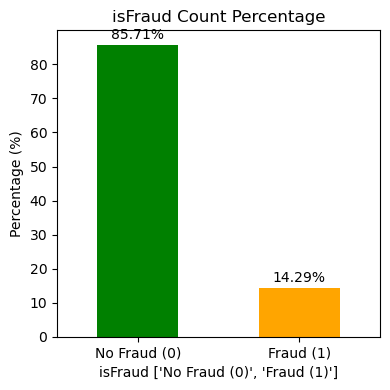

In [8]:
plot_percentage_chart(transaction,"isFraud",['No Fraud (0)', 'Fraud (1)'])

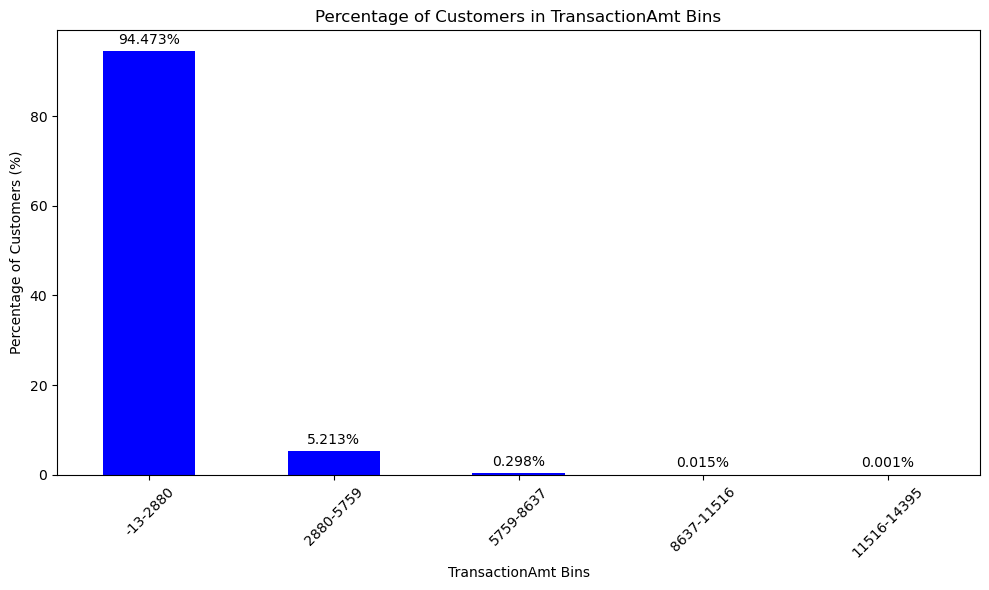

In [9]:
def plot_customer_percentage_chart(df,continuous_column, num_bins=10):
    """
    Plot a chart displaying bins of 'amount_requested' and the percentage of customers in each bin.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data with 'amount_requested' column.
    num_bins (int): Number of bins for the histogram. Default is 10.

    Returns:
    None (displays the chart)
    """
    # Create bins for 'amount_requested'
    bins, bin_edges = pd.cut(df[continuous_column], bins=num_bins, retbins=True)

    # Calculate percentage of customers in each bin
    total_customers = len(df)
    customer_percentage = df.groupby(bins).size() / total_customers * 100

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    ax = customer_percentage.plot(kind='bar', color='blue')

    # Add labels and title
    plt.xlabel('{} Bins'.format(continuous_column))
    plt.ylabel('Percentage of Customers (%)')
    plt.title('Percentage of Customers in {} Bins'.format(continuous_column))

    # Display the percentage on top of the bars
    for i, v in enumerate(customer_percentage):
        ax.text(i, v + 1, f'{v:.3f}%', ha='center', va='bottom')

    # Set x-axis labels as bin ranges
    bin_ranges = [f'{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}' for i in range(len(bin_edges)-1)]
    ax.set_xticks(range(len(bin_ranges)))
    ax.set_xticklabels(bin_ranges, rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_customer_percentage_chart(transaction,"TransactionAmt", num_bins=5)


In [10]:
bins, bin_edges = pd.cut(transaction["TransactionAmt"], bins=5, retbins=True)

In [11]:
transaction.groupby(bins)["isFraud"].sum()

TransactionAmt
(-13.394, 2879.8]     16411
(2879.8, 5758.6]       3430
(5758.6, 8637.4]        218
(8637.4, 11516.2]         8
(11516.2, 14395.0]        2
Name: isFraud, dtype: int64

In [12]:
transaction.groupby(bins)["isFraud"].sum() / transaction.groupby(bins).size()

TransactionAmt
(-13.394, 2879.8]     0.123666
(2879.8, 5758.6]      0.468451
(5758.6, 8637.4]      0.521531
(8637.4, 11516.2]     0.380952
(11516.2, 14395.0]    1.000000
dtype: float64

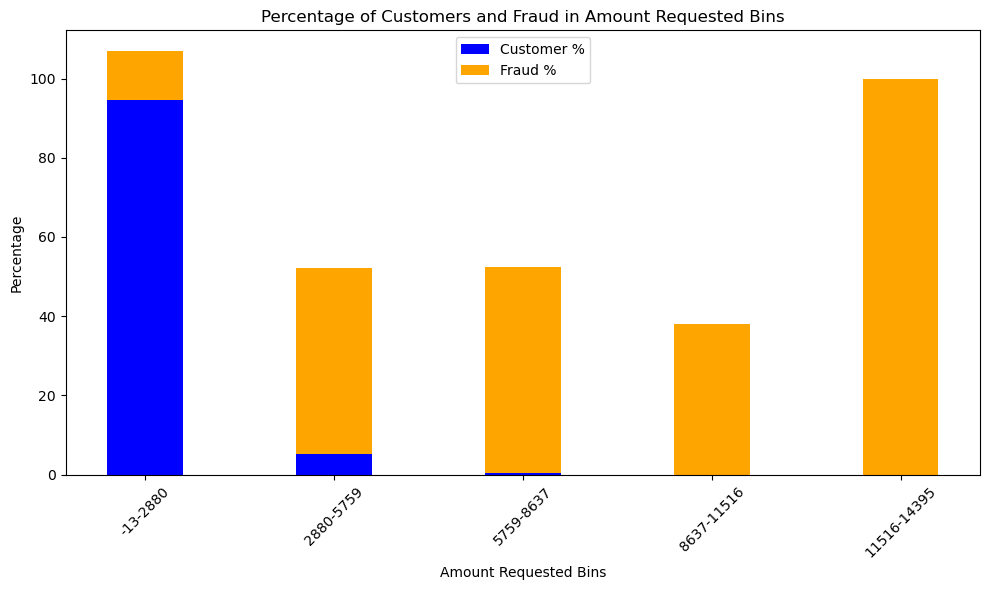

In [13]:
def plot_customer_fraud_percentage_chart(df,group_column,numerical_column, num_bins=10):

    # Create bins for 'amount_requested'
    bins, bin_edges = pd.cut(df[numerical_column], bins=num_bins, retbins=True)

    # Calculate percentage of customers and fraud in each bin
    total_customers = len(df)
    customer_percentage = df.groupby(bins).size() / total_customers * 100
    fraud_percentage = (df.groupby(bins)[group_column].sum() / df.groupby(bins)[group_column].size()) * 100

    # Plot the stacked bar chart
    plt.figure(figsize=(10, 6))
    width = 0.4  # Width of the bars
    ind = range(len(customer_percentage))

    plt.bar(ind, customer_percentage, width, label='Customer %', color='blue')
    plt.bar(ind, fraud_percentage, width, label='Fraud %', color='orange', bottom=customer_percentage)

    # Add labels and title
    plt.xlabel('Amount Requested Bins')
    plt.ylabel('Percentage')
    plt.title('Percentage of Customers and Fraud in Amount Requested Bins')

    # Set x-axis labels as bin ranges
    bin_ranges = [f'{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}' for i in range(len(bin_edges)-1)]
    plt.xticks(ind, bin_ranges, rotation=45)

    # Show the plot
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_customer_fraud_percentage_chart(transaction,"isFraud","TransactionAmt", num_bins=5)


In [14]:
transaction.describe().T

,count,mean,std,min,25%,50%,75%,max
card_no,140467.0,3.874164e+17,1.262482e+18,6.040010e+10,1.800094e+14,3.513191e+15,4.622077e+15,4.999793e+18
TransactionAmt,140467.0,9.977474e+02,9.993402e+02,1.000000e+00,2.860000e+02,6.910000e+02,1.384000e+03,1.439500e+04
isFraud,140467.0,1.428734e-01,3.499450e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [15]:
transaction.head()

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud
0,4e481ebc-c0a3-4682-92bb-852a51707c3f,2023-01-15 00:00:20,3572146632952415,JCB 16 digit,hotmail.com,45,669,1
1,6023c48d-1a0b-4639-b2b9-9dd84e5624a3,2023-01-15 00:00:44,5345027347086361,Maestro,mathis.com,Y,2924,0
2,9b81b063-6d23-485e-9c32-91303a0f96e0,2023-01-15 00:02:18,213121287312208,VISA 16 digit,yahoo.com,L,704,0
3,773b7155-d33b-4437-a961-8ff6577bf203,2023-01-15 00:03:01,4963405922548475459,Diners Club / Carte Blanche,rodriguez.com,45,6045,1
4,ac5b8170-be23-494f-aa58-7fe6ad5f2cc0,2023-01-15 00:03:24,3507208774395447,VISA 13 digit,jefferson.com,L,330,0


In [16]:
transaction["card_no4"] = transaction["card_no"].apply(lambda x: 'C' + str(x)[-4:])

In [17]:
transaction.head()

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud,card_no4
0,4e481ebc-c0a3-4682-92bb-852a51707c3f,2023-01-15 00:00:20,3572146632952415,JCB 16 digit,hotmail.com,45,669,1,C2415
1,6023c48d-1a0b-4639-b2b9-9dd84e5624a3,2023-01-15 00:00:44,5345027347086361,Maestro,mathis.com,Y,2924,0,C6361
2,9b81b063-6d23-485e-9c32-91303a0f96e0,2023-01-15 00:02:18,213121287312208,VISA 16 digit,yahoo.com,L,704,0,C2208
3,773b7155-d33b-4437-a961-8ff6577bf203,2023-01-15 00:03:01,4963405922548475459,Diners Club / Carte Blanche,rodriguez.com,45,6045,1,C5459
4,ac5b8170-be23-494f-aa58-7fe6ad5f2cc0,2023-01-15 00:03:24,3507208774395447,VISA 13 digit,jefferson.com,L,330,0,C5447


In [18]:
transaction.groupby(["card_type"]).size()

card_type
American Express               11304
Diners Club / Carte Blanche    12112
Discover                       11798
JCB 15 digit                   11443
JCB 16 digit                   23584
Maestro                        11888
Mastercard                     11961
VISA 13 digit                  11606
VISA 16 digit                  23288
VISA 19 digit                  11483
dtype: int64

In [19]:
import pandas as pd

def calculate_fraud_percentage(df, categorical_column, fraud_column='fraud'):
    grouped = df.groupby(categorical_column)[fraud_column].agg(
        total_count='count',
        fraud_count=lambda x: x.sum()
    )

    grouped['fraud_percentage'] = (grouped['fraud_count'] / grouped['total_count']) * 100

    return grouped.sort_values(by='fraud_percentage', ascending=False)

In [20]:
categorical_columns = ['card_type','email_domain','ProductCD','card_no4']

for col in categorical_columns:
    fraud_percentages_df = calculate_fraud_percentage(transaction, col,"isFraud")
    print("Fraud Percentages by Category:\n", fraud_percentages_df)

Fraud Percentages by Category:
                              total_count  fraud_count  fraud_percentage
card_type                                                              
Diners Club / Carte Blanche        12112         2223         18.353699
JCB 15 digit                       11443         2079         18.168313
Maestro                            11888         2142         18.018170
American Express                   11304         1529         13.526185
Mastercard                         11961         1616         13.510576
VISA 19 digit                      11483         1501         13.071497
JCB 16 digit                       23584         3056         12.957938
VISA 13 digit                      11606         1489         12.829571
VISA 16 digit                      23288         2986         12.822054
Discover                           11798         1448         12.273267
Fraud Percentages by Category:
                        total_count  fraud_count  fraud_percentage
email_

/tmp/ipykernel_7798/3513998276.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  transaction['Week'] = transaction['TransactionDT'].dt.week


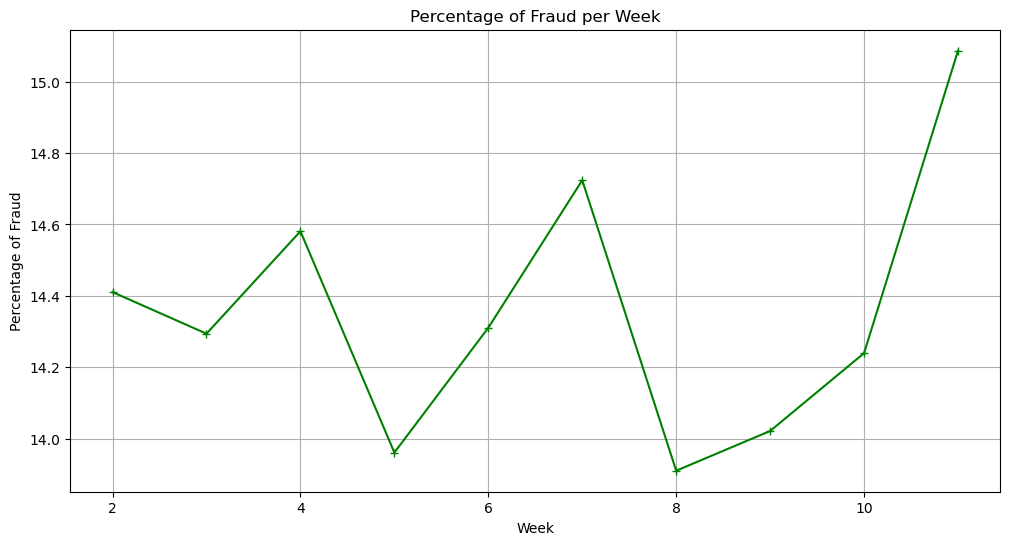

In [26]:
# Parse 'TransactionDT' as a datetime
transaction['TransactionDT'] = pd.to_datetime(transaction['TransactionDT'])

#week 
transaction['Week'] = transaction['TransactionDT'].dt.week
#transaction['day'] = transaction['TransactionDT'].dt.week

# percentage of fraud per week
fraud_percentage_per_week = transaction.groupby('Week')['isFraud'].mean() * 100

# timeseries chart
plt.figure(figsize=(12, 6))
fraud_percentage_per_week.plot(kind='line', marker='+', color='g')
plt.title('Percentage of Fraud per Week')
plt.xlabel('Week')
plt.ylabel('Percentage of Fraud')
plt.grid(True)
plt.show()


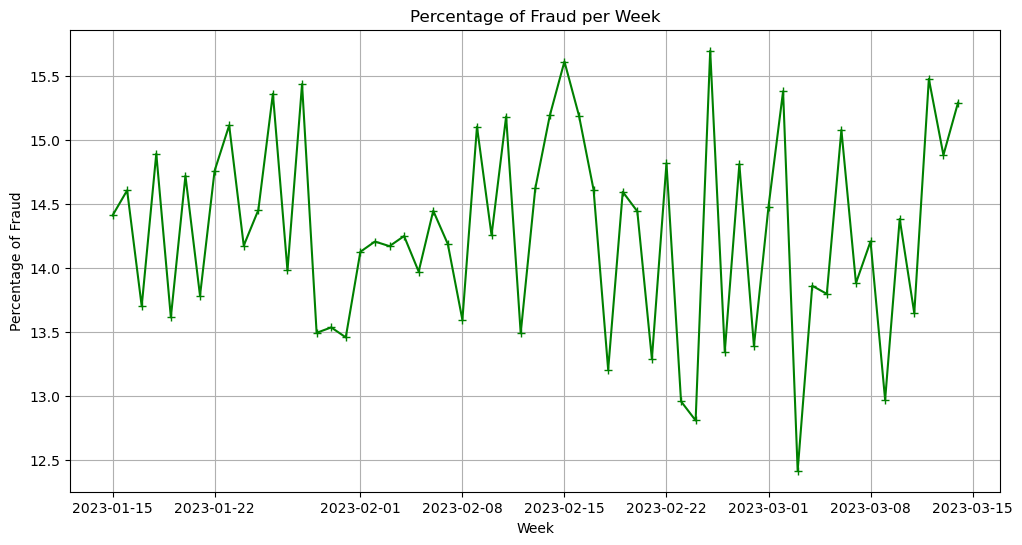

In [25]:
# Extract day information
transaction['day'] = transaction['TransactionDT'].dt.date

# percentage of fraud per week
fraud_percentage_per_week = transaction.groupby('day')['isFraud'].mean() * 100

# timeseries chart
plt.figure(figsize=(12, 6))
fraud_percentage_per_week.plot(kind='line', marker='+', color='g')
plt.title('Percentage of Fraud per Week')
plt.xlabel('Week')
plt.ylabel('Percentage of Fraud')
plt.grid(True)
plt.show()

In [29]:
transaction['hour'] = transaction['TransactionDT'].dt.hour

In [30]:
transaction.head()

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud,card_no4,Week,day,hour
0,4e481ebc-c0a3-4682-92bb-852a51707c3f,2023-01-15 00:00:20,3572146632952415,JCB 16 digit,hotmail.com,45,669,1,C2415,2,2023-01-15,0
1,6023c48d-1a0b-4639-b2b9-9dd84e5624a3,2023-01-15 00:00:44,5345027347086361,Maestro,mathis.com,Y,2924,0,C6361,2,2023-01-15,0
2,9b81b063-6d23-485e-9c32-91303a0f96e0,2023-01-15 00:02:18,213121287312208,VISA 16 digit,yahoo.com,L,704,0,C2208,2,2023-01-15,0
3,773b7155-d33b-4437-a961-8ff6577bf203,2023-01-15 00:03:01,4963405922548475459,Diners Club / Carte Blanche,rodriguez.com,45,6045,1,C5459,2,2023-01-15,0
4,ac5b8170-be23-494f-aa58-7fe6ad5f2cc0,2023-01-15 00:03:24,3507208774395447,VISA 13 digit,jefferson.com,L,330,0,C5447,2,2023-01-15,0


In [32]:
categorical_columns = ['hour']

for col in categorical_columns:
    fraud_percentages_df = calculate_fraud_percentage(transaction, col,"isFraud")
    print("Fraud Percentages by Category:\n", fraud_percentages_df.sort_values("hour",ascending=[True]))

Fraud Percentages by Category:
       total_count  fraud_count  fraud_percentage
hour                                            
0            5881          841         14.300289
1            5623          780         13.871599
2            6000          880         14.666667
3            5776          871         15.079640
4            5888          830         14.096467
5            5919          910         15.374219
6            5838          811         13.891744
7            5726          850         14.844569
8            5791          834         14.401658
9            5849          804         13.745939
10           5785          816         14.105445
11           5822          879         15.097905
12           5769          814         14.109898
13           5967          827         13.859561
14           5878          799         13.593059
15           5950          807         13.563025
16           5752          769         13.369263
17           5912          850       

In [33]:
df_all = pd.merge(transaction,identity,how="left",on="TransactionID")

In [34]:
df_all.shape

(140467, 15)

In [35]:
df_all.head()

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud,card_no4,Week,day,hour,IpAddress,PhoneNo,DeviceID
0,4e481ebc-c0a3-4682-92bb-852a51707c3f,2023-01-15 00:00:20,3572146632952415,JCB 16 digit,hotmail.com,45,669,1,C2415,2,2023-01-15,0,139.156.81.68,(701)110-8664,6812241985313
1,6023c48d-1a0b-4639-b2b9-9dd84e5624a3,2023-01-15 00:00:44,5345027347086361,Maestro,mathis.com,Y,2924,0,C6361,2,2023-01-15,0,188.167.107.154,651-708-4634x5968,9618531295327
2,9b81b063-6d23-485e-9c32-91303a0f96e0,2023-01-15 00:02:18,213121287312208,VISA 16 digit,yahoo.com,L,704,0,C2208,2,2023-01-15,0,72.42.62.66,412-762-7325,6139189388260
3,773b7155-d33b-4437-a961-8ff6577bf203,2023-01-15 00:03:01,4963405922548475459,Diners Club / Carte Blanche,rodriguez.com,45,6045,1,C5459,2,2023-01-15,0,215.32.234.191,+1-389-448-2305x492,5790632409351
4,ac5b8170-be23-494f-aa58-7fe6ad5f2cc0,2023-01-15 00:03:24,3507208774395447,VISA 13 digit,jefferson.com,L,330,0,C5447,2,2023-01-15,0,107.153.65.180,+1-028-769-3676x5605,4279379318023


In [43]:
df_all["ipLastPart"] = df_all["IpAddress"].apply(lambda x: x.split('.')[-1])
df_all["device_no4"] = df_all["DeviceID"].apply(lambda x: 'D' + str(x)[-4:])

In [44]:
df_all.head()

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud,card_no4,Week,day,hour,IpAddress,PhoneNo,DeviceID,ipLastPart,device_no4
0,4e481ebc-c0a3-4682-92bb-852a51707c3f,2023-01-15 00:00:20,3572146632952415,JCB 16 digit,hotmail.com,45,669,1,C2415,2,2023-01-15,0,139.156.81.68,(701)110-8664,6812241985313,68,D5313
1,6023c48d-1a0b-4639-b2b9-9dd84e5624a3,2023-01-15 00:00:44,5345027347086361,Maestro,mathis.com,Y,2924,0,C6361,2,2023-01-15,0,188.167.107.154,651-708-4634x5968,9618531295327,154,D5327
2,9b81b063-6d23-485e-9c32-91303a0f96e0,2023-01-15 00:02:18,213121287312208,VISA 16 digit,yahoo.com,L,704,0,C2208,2,2023-01-15,0,72.42.62.66,412-762-7325,6139189388260,66,D8260
3,773b7155-d33b-4437-a961-8ff6577bf203,2023-01-15 00:03:01,4963405922548475459,Diners Club / Carte Blanche,rodriguez.com,45,6045,1,C5459,2,2023-01-15,0,215.32.234.191,+1-389-448-2305x492,5790632409351,191,D9351
4,ac5b8170-be23-494f-aa58-7fe6ad5f2cc0,2023-01-15 00:03:24,3507208774395447,VISA 13 digit,jefferson.com,L,330,0,C5447,2,2023-01-15,0,107.153.65.180,+1-028-769-3676x5605,4279379318023,180,D8023
